<a href="https://colab.research.google.com/github/ThomasAlbin/Astroniz-YT-Tutorials/blob/main/model_v3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import modules
import os

import numpy as np
import pandas as pd

import ipywidgets
from matplotlib import pyplot as plt

In [2]:
# Mount the gdrive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# Set the core path where the spectra are present
core_path = "/gdrive/MyDrive/Colab/CDAspec/"

In [4]:
# Load the training and unknown CDA spectra
cda_qm_train_df = pd.read_parquet(os.path.join(core_path, "level1b/training/", "cda_qm_spectra_labeled_pre2008039_lvl1b.parquet"))
cda_qm_unknw_df = pd.read_parquet(os.path.join(core_path, "level1b/unknown/", "cda_qm_spectra_unknown_pre2008039_lvl1b.parquet"))

In [ ]:
# Re-classify the bad 3-P spectra
#bad_3P = np.array([1530400657, 1561718753, 1571950822, 1540714643])

#cda_qm_train_df.loc[:, "class"] = cda_qm_train_df.apply(lambda x: x["class"] if not any(np.isin(bad_3P, x["sclk"])) else "?", axis=1)

In [ ]:
def spec(df, aug=False):

    df.loc[:, "spectrum_pre"] = df["spectrum"].apply(lambda x: x[:400])
    df.loc[:, "spectrum_after"] = df["spectrum"].apply(lambda x: x[400:])

    df.loc[:, "spectrum_pre_max"] = df["spectrum_pre"].apply(lambda x: np.max(x))
    df.loc[:, "spectrum_after_max"] = df["spectrum_after"].apply(lambda x: np.max(x))

    df.loc[:, "multiplier"] = df["spectrum_pre_max"] / df["spectrum_after_max"]

    df.loc[:, "spectrum_after"] = df.apply(lambda x: x["multiplier"] * x["spectrum_after"], axis=1)

    df.loc[:, "spectrum"] = df.apply(lambda x: np.hstack([x["spectrum_pre"], x["spectrum_after"]]), axis=1)


    if aug:
        for index, row in df.loc[df["class"] == "3-P"].iterrows():
            for k in np.linspace(0.01, 0.1, 100):
                temp_main = row["spectrum"] + np.random.normal(loc=0.0, scale=k*np.std(row["spectrum"]), size=(690))
                temp = pd.DataFrame({"spectrum": [temp_main],
                                     "class": ["3-P"]})
                
                df = pd.concat([df, temp])
                df.reset_index(drop=True, inplace=True)

    df.loc[:, "spectrum"] = df["spectrum"].apply(lambda x: x + np.abs(np.min(x)))
    df.loc[:, "spectrum"] = df["spectrum"].apply(lambda x: x / np.max(x))

    df.drop(columns=["spectrum_pre", "spectrum_after", "multiplier"], inplace=True)

    return df

cda_qm_train_df = spec(cda_qm_train_df, aug=True)
cda_qm_unknw_df = spec(cda_qm_unknw_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
cda_qm_train_df["class"].unique()

array(['4', '1', '?', '3', 'Noise', '5', '2', '3-Car', '3-OH', '3-KNa',
       '3-K', '3-P', '3-Cl'], dtype=object)

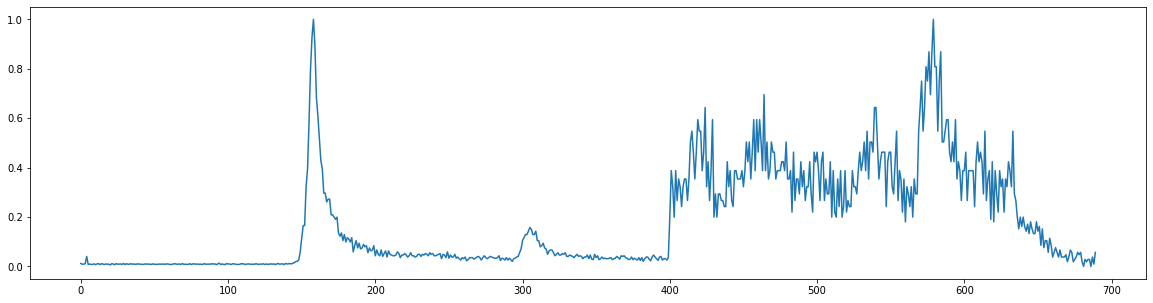

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(cda_qm_train_df.loc[cda_qm_train_df["class"] == "3-P"]["spectrum"].iloc[0])

In [ ]:
cda_qm_train_negative_df = cda_qm_train_df.loc[cda_qm_train_df["class"].isin(['4', '1', '?', 'Noise', '5', '2', '3-KNa', '3-K', '3', '3-Car', '3-OH', "3-Cl"])]
cda_qm_train_positive_df = cda_qm_train_df.loc[cda_qm_train_df["class"].isin(["3-P"])]

In [ ]:
X_train_pos_org = np.array(cda_qm_train_positive_df["spectrum"].tolist())
X_train_neg_org = np.array(cda_qm_train_negative_df["spectrum"].tolist())
X_train = np.vstack([X_train_pos_org, X_train_neg_org])

X_unknw_org = np.array(cda_qm_unknw_df["spectrum"].tolist())

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_unknw_org = np.expand_dims(X_unknw_org, axis=2)

In [ ]:
y_train_pos = np.zeros((len(X_train_pos_org), 2))
y_train_pos[:, 0] = 1

y_train_neg = np.zeros((len(X_train_neg_org), 2))
y_train_neg[:, 1] = 1

y_train_pre = np.vstack([y_train_pos, y_train_neg])

# Create the model

In [ ]:
import sklearn.metrics
# Naive Baseline

# We copy the original labelling and shuffle it randomly
y_random_train = y_train_pre.copy()
np.random.shuffle(y_random_train)

f1_score_naive = round(sklearn.metrics.f1_score(np.argmax(y_train_pre, axis=1), np.argmax(y_random_train, axis=1)), 5)
print(f"Naive F1 Score: {f1_score_naive}")

Naive F1 Score: 0.88424


In [ ]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(X_train, y_train_pre):
    
    X_train, X_test = X_train[train_index], X_train[test_index]
    y_train, y_test = y_train_pre[train_index], y_train_pre[test_index]

In [ ]:
# We need to create weights for our samples. Similar like the class weights, but here, our classes
# are one-hot encoded. Sample weights are easier to handle!
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [ ]:
import tensorflow.keras as keras

# Get the number of inputs
n_inputs = X_train.shape[1]

def create_model():

    normalizer = keras.layers.Normalization(axis=1)
    normalizer.adapt(X_train)
    
    # model1: 32 64 128 @231
    # model2: 64 128 256 @231
    # model3: 32 32 64 64 128 128 @231

    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs, 1))

    hidden_layer = keras.layers.Conv1D(filters=64,
                                       activation="relu",
                                       kernel_size=3)(input_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)


    hidden_layer = keras.layers.Conv1D(filters=128,
                                       activation="relu",
                                       kernel_size=3)(hidden_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Conv1D(filters=256,
                                       activation="relu",
                                       kernel_size=3)(hidden_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    #hidden_layer = keras.layers.Conv1D(filters=128,
     #                                  activation="relu",
      #                                 kernel_size=3)(hidden_layer)
    #hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Flatten()(hidden_layer)
#    hidden_layer = keras.layers.Dense(16, activation="relu")(hidden_layer)

    output_layer = keras.layers.Dense(2, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Show the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 690, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 688, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 344, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 342, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 171, 128)         0         
 1D)                                                             
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 85, 128)          0     

In [ ]:
# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# The training won't take long. Let's exceed the number of epochs
end_epoch = 400
batch_size = 128

# And train! With a validation split of 25 % and the splitting prior we have:
# Training: 60 %
# Validation: 20 %
# Test: 20 %
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1, 
                    validation_split=0.25,
                    sample_weight=sample_weight,
                    callbacks=[es_callback])

Epoch 1/400
103/103 [==============================] - 15s 29ms/step - loss: 0.2538 - val_loss: 0.0429
Epoch 2/400
103/103 [==============================] - 1s 11ms/step - loss: 0.0312 - val_loss: 0.0212
Epoch 3/400
103/103 [==============================] - 1s 11ms/step - loss: 0.0164 - val_loss: 0.0119
Epoch 4/400
103/103 [==============================] - 1s 11ms/step - loss: 0.0077 - val_loss: 0.0047
Epoch 5/400
103/103 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 6/400
103/103 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 7/400
103/103 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 8/400
103/103 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 9/400
103/103 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/400
103/103 [==============================] - 1s 11ms/step - loss: 7.99

Text(0, 0.5, 'Loss')

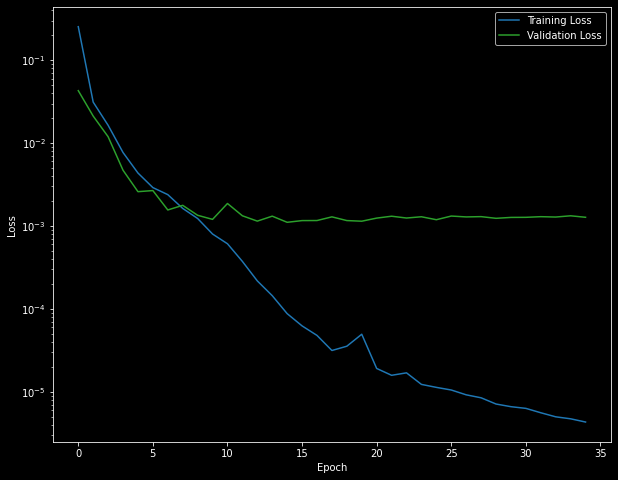

In [ ]:
# Let's plot the losses
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(10, 8))

plt.plot(history.history["loss"], color="tab:blue", label="Training Loss")
plt.plot(history.history["val_loss"], color="tab:green", label="Validation Loss")

plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
# Compute class probabilities
y_test_prop_pred = model.predict(X_test)

# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1

In [ ]:
y_test_binary = np.argmax(y_test, axis=1)
y_test_pred_binary = np.argmax(y_test_oh_pred, axis=1)

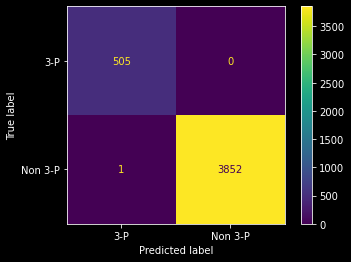

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(y_test_binary,
                            y_test_pred_binary,
                            labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["3-P", "Non 3-P"])
disp.plot()
plt.show()

In [ ]:
#model.save('/gdrive/MyDrive/Colab/CDAspec/model3')

In [ ]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(y_test_binary,
                                          y_test_pred_binary,
                                          average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 1.0


In [ ]:
y_unknown_prop_pred = model.predict(X_unknw_org)

y_unknown_pred = np.zeros_like(y_unknown_prop_pred)
y_unknown_pred[np.arange(len(y_unknown_prop_pred)), y_unknown_prop_pred.argmax(1)] = 1

In [ ]:
np.sum(y_unknown_pred, axis=0)

array([2.000000e+01, 1.034021e+06], dtype=float32)

In [ ]:
cda_qm_unknw_df.loc[:, "3_P"] = np.array([y_unknown_pred[:, 0]]).T

In [ ]:
cda_qm_unknw_df.loc[cda_qm_unknw_df["3_P"] == 1]

,sclk,spectrum,spectrum_length,spectrum_pre_max,spectrum_after_max,3_P
234673,1511775709,"[0.08387425, 0.1341988, 0.1006491, 0.0670994, ...",1018,0.000010,0.000064,1.0
237997,1511795230,"[0.008812322, 0.009913863, 0.011015403, 0.0088...",1018,0.000157,0.000015,1.0
241638,1511815128,"[0.03841574, 0.03734233, 0.036268916, 0.036268...",1018,0.000157,0.000010,1.0
259922,1514101038,"[8.730273e-06, 8.730273e-06, 8.730273e-06, 8.7...",1018,0.375263,0.294149,1.0
380670,1506226797,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",1018,0.000010,0.000000,1.0
387314,1506669500,"[0.24195556, 0.24195556, 0.24195556, 0.2217926...",1018,0.000008,0.000045,1.0
416455,1541620191,"[6.9769662e-06, 7.3645756e-06, 6.9769662e-06, ...",1018,0.450602,0.478963,1.0
433009,1543925371,"[9.988851e-06, 9.988851e-06, 9.988851e-06, 9.9...",1018,0.332219,0.260477,1.0
437437,1544853756,"[0.18330234, 0.18270868, 0.18181819, 0.1824118...",1018,0.000481,0.000003,1.0
445412,1546300161,"[0.1139543, 0.11279419, 0.11047394, 0.11279419...",1018,0.000134,0.000007,1.0


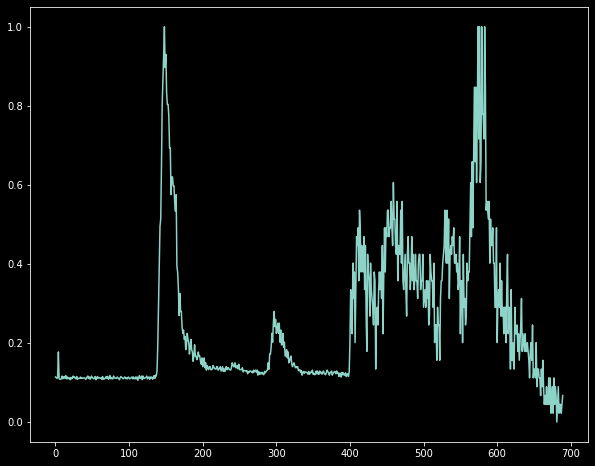

In [ ]:
#plt.plot(np.log10(cda_qm_unknw_df.loc[cda_qm_unknw_df["3_P"] == 1]["spectrum"].iloc[1400]))
plt.figure(figsize=(10, 8))
plt.plot(cda_qm_unknw_df.loc[cda_qm_unknw_df["3_P"] == 1]["spectrum"].iloc[9])

In [ ]:
cda_qm_unknw_df.loc[cda_qm_unknw_df["3_P"] == 1]["sclk"]

234673    1511775709
237997    1511795230
241638    1511815128
259922    1514101038
380670    1506226797
387314    1506669500
416455    1541620191
433009    1543925371
437437    1544853756
445412    1546300161
505021    1519581464
529994    1521585607
560806    1524914246
616651    1528981124
617960    1529220871
712645    1571891871
714070    1571895102
783233    1575405758
883235    1558931441
987526    1567095231
Name: sclk, dtype: int64

In [ ]:
cda_qm_unknw_preload_df = pd.read_parquet(os.path.join(core_path, "level1b/unknown/", "cda_qm_spectra_unknown_pre2008039_lvl1b.parquet"))
#cda_qm_train_df

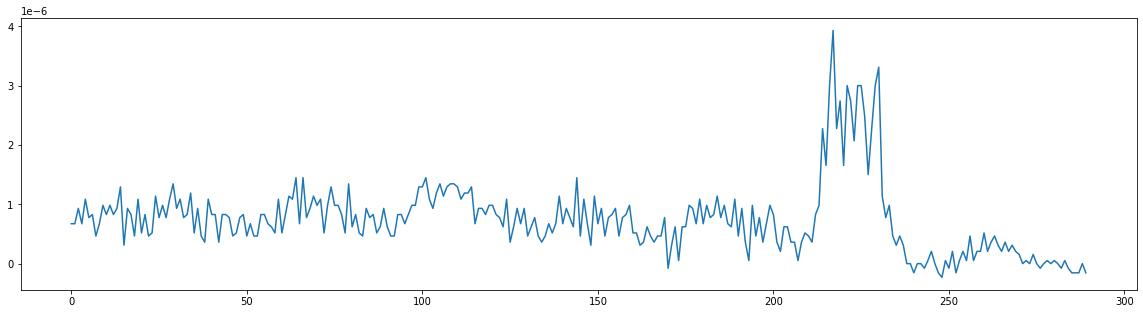

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(np.log10(cda_qm_train_df.loc[cda_qm_train_df["sclk"] == 1575416383]["spectrum"].iloc[0][400:]+1))

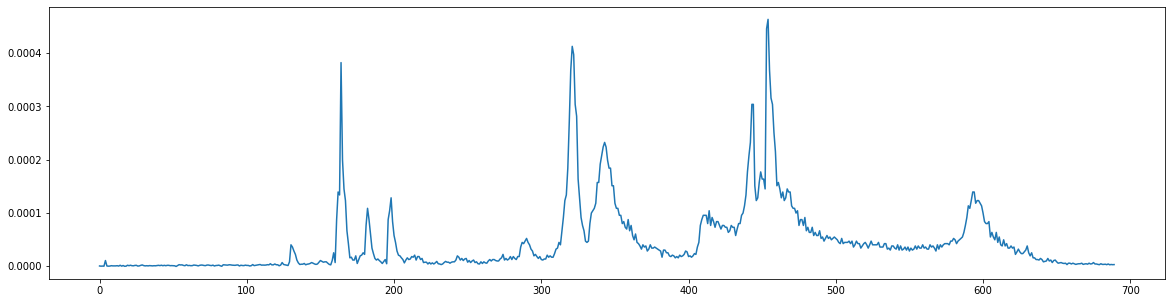

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(cda_qm_unknw_preload_df.loc[cda_qm_unknw_preload_df["sclk"] == 1578095631]["spectrum"].iloc[0])